In [1]:
# Imports
import torch
from torch.distributions import Normal,Uniform,Gamma,Laplace,OneHotCategorical
import os
import time
from functools import partial

from causal_cocycle.kernels import *
from causal_cocycle.kde import *
from causal_cocycle.regression_functionals import *
from causal_cocycle.distribution_estimation import *
from causal_cocycle.helper_functions import propensity_score

from BD import *

import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICSCORE_LIB_OK"]="TRUE"

In [2]:
# DGP set up
seed = 0 
N = 5000
D = 10
Zcorr = 0.0
flip_prob = 0.05
coeffs = 1/torch.linspace(1,D,D)[:,None]**1
coeffs *= 1/coeffs.sum()
means = torch.tensor([[-2, 0]]).T # means for mixture U dist
scales = torch.tensor([[-1.0, 1.0]]).T  # variances for mixture U dist
probabilities = torch.tensor([1/2,1/2]) # mixture probs for mixture U dist
base_dists = [IG(10,10),IG(1,1)]
noise_dist = Mixture1D(base_dists,probabilities,means,scales)
Zdist1 = Normal(0,1.5)
Zdist2 = Normal(0,1.5)
feature = lambda x,t: (torch.sigmoid(x)<=t.T).float()

In [46]:
# Method + opt set up
functional = KRR_functional
kernel = gaussian_kernel
subsample = False
subsamples = N
nfold = 5
ls_method = "med_heuristic"
hyper_lambda = 2**torch.linspace(-10,0,5)
hyper_ls = 2**torch.linspace(-5,5,5)

hyper_grid_lambda = hyper_lambda.repeat(len(hyper_ls))
hyper_grid_ls = torch.repeat_interleave(hyper_ls,len(hyper_lambda))
assert(len(hyper_grid_lambda) == len(hyper_grid_ls))

t_train = torch.linspace(0,1,1000)[:,None]

In [47]:
# DGP
torch.manual_seed(seed)
Z1,X1,Y1 = DGP(N,D,partial(policy,flip_prob = flip_prob),coeffs,Zcorr,Zdist1,noise_dist)
Z2,X2,Y2 = DGP(N,D,partial(policy,flip_prob = flip_prob),coeffs,Zcorr,Zdist2,noise_dist)
Z,X,Y = (torch.row_stack((Z1,Z2)),
         torch.row_stack((X1,X2)),
         torch.row_stack((Y1,Y2)))

In [48]:
# Training on data
inputs_train = X
outputs_train = feature(Y,t_train).float()

# Getting median heuristic lengthscale
Distances= torch.tril((X[...,None]-X[...,None].T)**2)
ls = torch.ones(D+1)
for d in range(D+1):
    ls[d] = (Distances[:,d][Distances[:,d]!=0].median()/2).sqrt()

# Defining hyper-grid for cross-validation
hyper_grid = []
for h in range(len(hyper_grid_lambda)):
    hyper_grid.append([hyper_grid_ls[h]*ls,hyper_grid_lambda[h]])
                      
# Defining model
k_x = kernel(lengthscale = torch.tensor(ls,requires_grad = True))
regressor = functional(k_x)
CE = Conditional_Expectation_Regressor(regressor)

# Doing CV over hypers
CE.CVgridsearch(inputs_train,outputs_train,
                        nfold = nfold, 
                        subsample = subsample,
                        subsamples = subsamples,
                        hyper_grid = hyper_grid,
                        norm = 1)

/tmp/ipykernel_1045152/3007653635.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k_x = kernel(lengthscale = torch.tensor(ls,requires_grad = True))


In [49]:
# Sampling from interventional distribution
nintsample = 5000
torch.manual_seed(seed)
Zint1,Xint1,Yint1 = DGP(nintsample,D,partial(new_policy),coeffs,Zcorr,Zdist1,noise_dist)
Zint2,Xint2,Yint2 = DGP(nintsample,D,partial(new_policy),coeffs,Zcorr,Zdist2,noise_dist)

In [50]:
# cdf values
t = torch.linspace(0,1,1000)[:,None]

# Getting CDF
kde_cdf_int1 = CE.forward(feature(Y2,t).float(),X2,Xint1).mean(0).detach()
kde_cdf_int2 = CE.forward(feature(Y1,t).float(),X1,Xint2).mean(0).detach()

# True cdf
true_cdf_int1 = feature(Yint1,t).mean(0)
true_cdf_int2 = feature(Yint2,t).mean(0)

In [35]:
# Training propensity score models
Propensity_score_model_est = []
Propensity_score_model_policy = []
Propensity_score_model_new_policy = []

# Estimating mistake probabilities
Xtrue = policy(Z)
states = torch.unique(X[:,0]).int()
nstate = len(states)
P = torch.zeros((nstate,nstate))
for i in range(nstate):
    for j in range(nstate):
        P[i,j] = ((X[:,0]==states[i])*(Xtrue[:,0]==states[j])).float().sum()
P *= 1/P.sum(0)

propensity_model_est = propensity_score(P,policy)
propensity_model_new_policy = propensity_score(torch.eye(len(P)),new_policy)  
propensity_model_policy = propensity_score(torch.eye(len(P)),policy)  

In [36]:
# Getting IPW estimator
weights_int1 = (propensity_model_new_policy(X1,Z1)/
                propensity_model_est(X1,Z1)).detach()

weights_int2 = (propensity_model_new_policy(X2,Z2)/
                propensity_model_est(X2,Z2)).detach()

#weights_int1 *= len(weights_int1)/weights_int1.sum()
#weights_int2 *= len(weights_int2)/weights_int2.sum()

IPW_cdf_int1 = (weights_int1[:,None]*feature(Y1,t)).mean(0)
IPW_cdf_int2 = (weights_int2[:,None]*feature(Y2,t)).mean(0)

In [37]:
# Getting DR estimator (start by adding on IPW term to outcome model
kde_DR_cdf_int1 = kde_cdf_int1 + IPW_cdf_int1
kde_DR_cdf_int2 = kde_cdf_int2 + IPW_cdf_int2

# Updating DR estimator
kde_DR_cdf_int1 -= (weights_int1[:,None]*CE.forward(feature(Y2,t).float(),X2,Xint1)).mean(0).detach()
kde_DR_cdf_int2 -= (weights_int2[:,None]*CE.forward(feature(Y1,t).float(),X1,Xint2)).mean(0).detach()

In [52]:
print((kde_cdf_int1 -true_cdf_int1).abs().mean())
print((IPW_cdf_int1 -true_cdf_int1).abs().mean())
print((kde_DR_cdf_int1 -true_cdf_int1).abs().mean())

print((kde_cdf_int2 -true_cdf_int2).abs().mean())
print((IPW_cdf_int2 -true_cdf_int2).abs().mean())
print((kde_DR_cdf_int2 -true_cdf_int2).abs().mean())

tensor(0.0130)
tensor(0.0542)
tensor(0.0341)
tensor(0.0107)
tensor(0.0256)
tensor(0.0210)


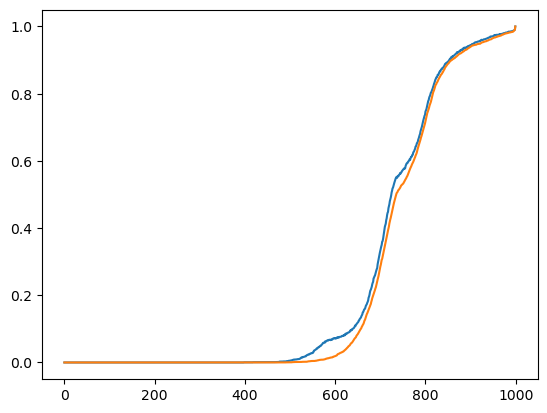

In [39]:
plt.plot(kde_cdf_int1)
plt.plot(true_cdf_int1)